# Individual Tree Identification in Native Forest Images

## Main Objective and Image Source
The main objective of this work is to identify and differentiate individual trees in drone-captured images of native forests. The specific images for this experiment are of a green area within the UFRRJ campus. There is a single stitched image of the whole flight and the tests and processing will be done in segments, such as the one below:
![sample image](test.png)

This application is intended to make forestry upkeep efforts less labor intensive. Today, making inventory of a forest requires frequent visits by foot. If there was a reliable method to observe previously catalogued trees with a drone survey, it would make the job of forest engineers much easier.

Images are provided by Professor [Bruno Mendonça](https://institutos.ufrrj.br/if/bruno-araujo-furtado-de-mendonca/) and Fernando Canto. They were obtained with support from FAPERJ and UFFRJ.

## Metodology
The main processing tasks involved will be image segmentation, to divide the images into individuals. Also, image description will be used to identify the segmented individuals' species. More specifically, the intended steps for the process are detailed below:

1. Get a dataset with many examples of each tree species present in these woods, as each one is a texture. As of now, I did this by eye and with one example per texture. This depends on the availability of the forest engineers involved and is scheduled to happen soon.

2. Compute the centroid of each sepecies' texture by its descriptors. As this domain does not have very strong edges or transitions, enhancements will have to be experimented with in order to differentiate the classes.

3. Segment the image into the textures. As of now, this is done by sliding a window through the main image and assigning it to its closest class. A better method is expected to be applied in the final approach.



## Initial Experiments and Results

### Overview

As of now, different textures were extracted from a test image(shown a little further). Their haralick descriptors were computed in similar fashion from the fifith course assignment. Then, the input image was divided into 120x120 chunks, and each was assigned to its closest texture according to euclidean distance between descriptors.

The results are far from complete, but even in this crude initial approach, there is some consistency within them.

### Next Steps

There are varying shades of green within the same species. So, if a classifier is sensible to the hue, it could make mistakes, as it is observed. The next thing to solve is make the descriptors invariant to small changes in green. The first approach to that, of course, is getting a larger dataset for each texture. Experiments with different color spaces also can help.

Other methods of segmentation shall also be tried. As there is no clear background beyond the gaps between trees, common algorithms such as watershed don't seem applicable so far, at least to my knowledge of it. Fractal Dimension(FD) segmentation is also a possible candidate, but there is a chance that the variation within the FD of trees could be to small to be reliable.

### Code

#### Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [2]:
from morph_texture import euclidean_distance, get_haralick, get_masks, normalize

#### Displaying Tools

In [3]:
def show(img, plt_size=(16, 10), cmap=None):
    fig = plt.figure(figsize=plt_size)
    plt.imshow(img, cmap=cmap if cmap is not None else (None if len(img.shape) == 3 else 'gray'))

#### Loading Test Image and Textures

In [4]:
img = imageio.imread('./test_img.png')
textures = [imageio.imread('../texons/{}.png'.format(i)) for i in range(1, 9)]

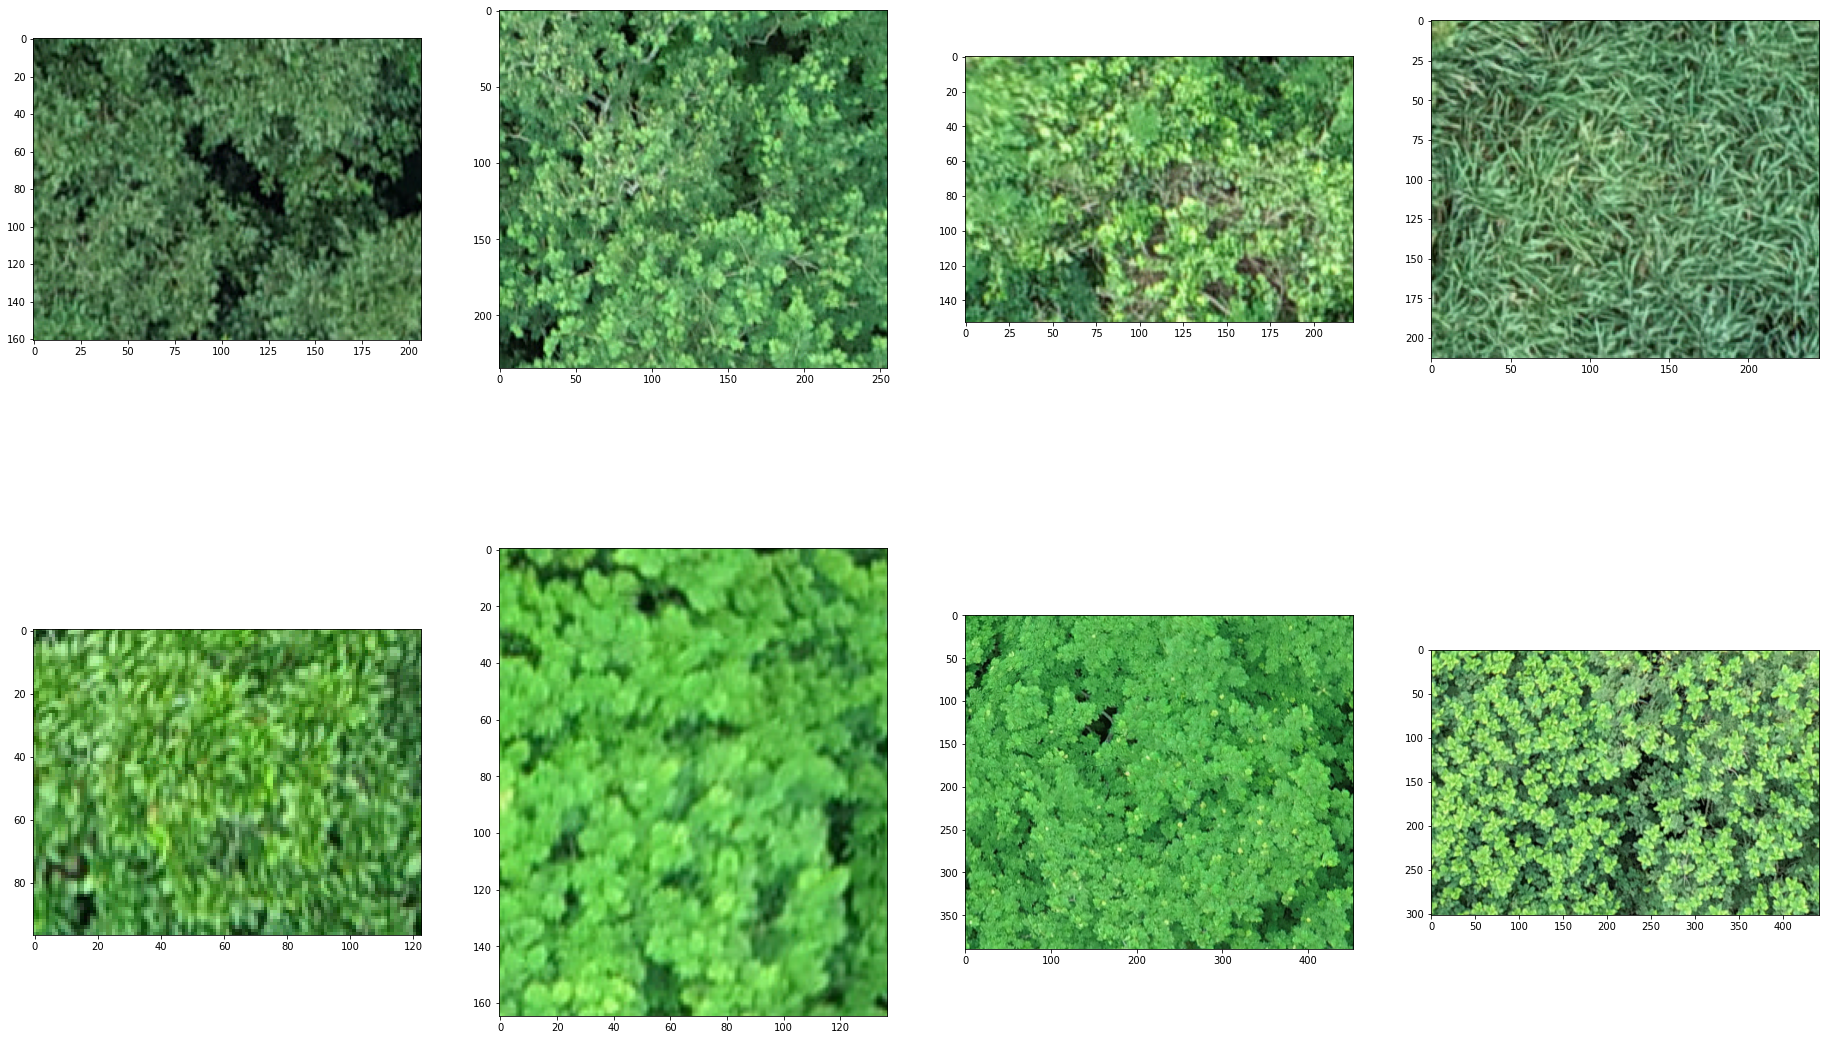

In [5]:
fig = plt.figure(figsize=(32, 20))
for i in range(len(textures)):
    plt.subplot(2, 4, i + 1); plt.imshow(textures[i])

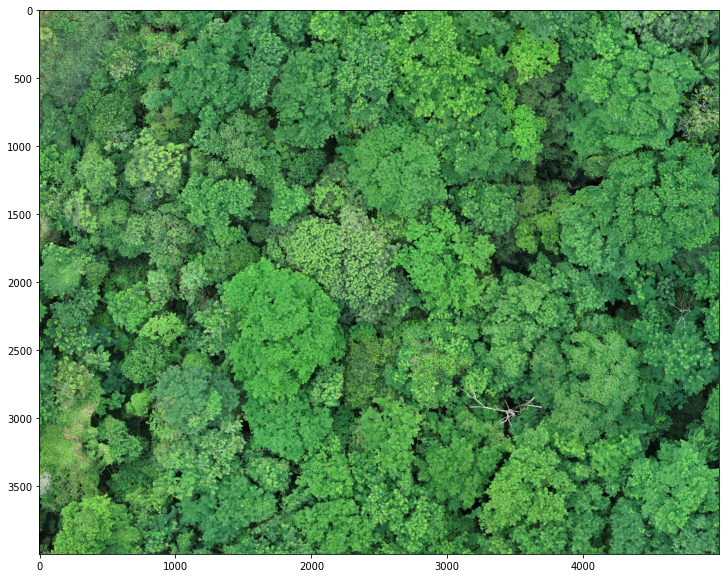

In [6]:
show(img)

#### Get Haralick Descriptors for Textures to use as Clusters' Centroids

In [7]:
def morph_f(img):
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]))

In [8]:
descriptors = []
for texture in textures:
    descriptors.append(np.concatenate([get_haralick(m, (0, 1)) for m in get_masks(texture, morph_f)]))

In [9]:
descriptors[0]

array([1.69474708e+03, 8.32185397e+02, 1.52495475e+01, 2.11911591e-01,
       7.36031198e+00, 4.91814577e-01, 5.22124481e-01, 4.60070563e-01,
       6.20761954e+03, 1.42260825e+03, 1.89394079e+01, 1.77622211e-01,
       7.62654529e+00, 4.53159947e-01, 4.86216098e-01, 4.21168891e-01])

#### Segment Image
Run a moving window and classify it accosrding to its closest centroid (texture)

In [10]:
def segment_by_sliding_window(img, window):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    result = np.zeros((img.shape[0] - (img.shape[0] % window[0]),
                       img.shape[1] - (img.shape[1] % window[1])))
    for h in range(0, img.shape[0], window[0]):
        for w in range(0, img.shape[1], window[1]):
            delta_h = min(h + window[0], img.shape[0] - 1)
            delta_w = min(w + window[1], img.shape[1] - 1)
            sub_img = img[h : delta_h, w : delta_w]
            sub_img_descr = np.concatenate([get_haralick(m, (0, 1)) for m in get_masks(sub_img, morph_f)])
            distances = [euclidean_distance(sub_img_descr, d) for d in descriptors]
            color = distances.index(min(distances)) * 1 / len(descriptors)
            result[h : delta_h, w : delta_w] = color
    return result

In [12]:
segmented = segment_by_sliding_window(img, (120, 120))

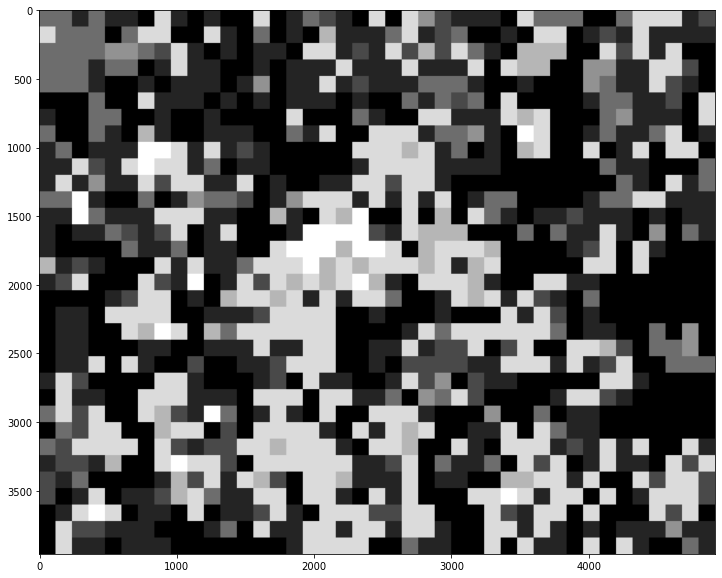

In [13]:
show(segmented)

#### Show Each Segment Separately
It's far from impressive, but there is some consistency. By sampling more of the textures and getting a more general representation, results could improve. Other segmentation algorithms will be tried as well.

In [14]:
clusters = np.unique(segmented)
masked = []
for cluster in clusters:
    mask = np.zeros_like(img)
    ids = np.where(segmented == cluster)
    mask[ids] = img[ids]
    masked.append(mask)
    

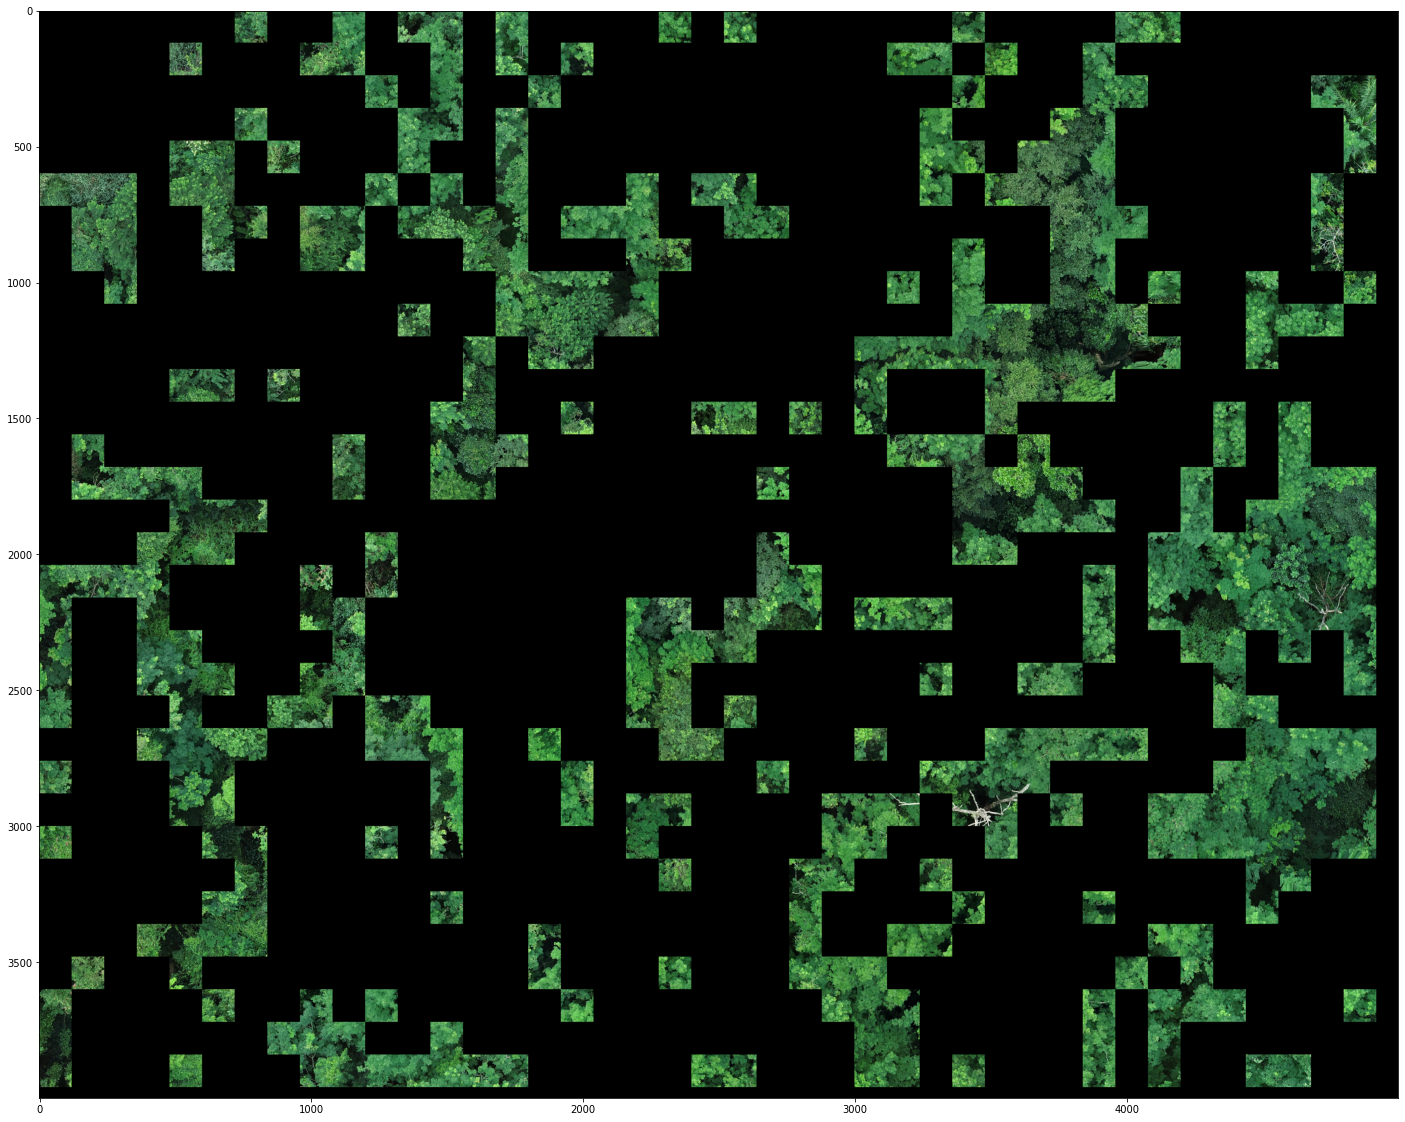

In [15]:
fig = plt.figure(figsize=(32, 20))
plt.imshow(masked[0])

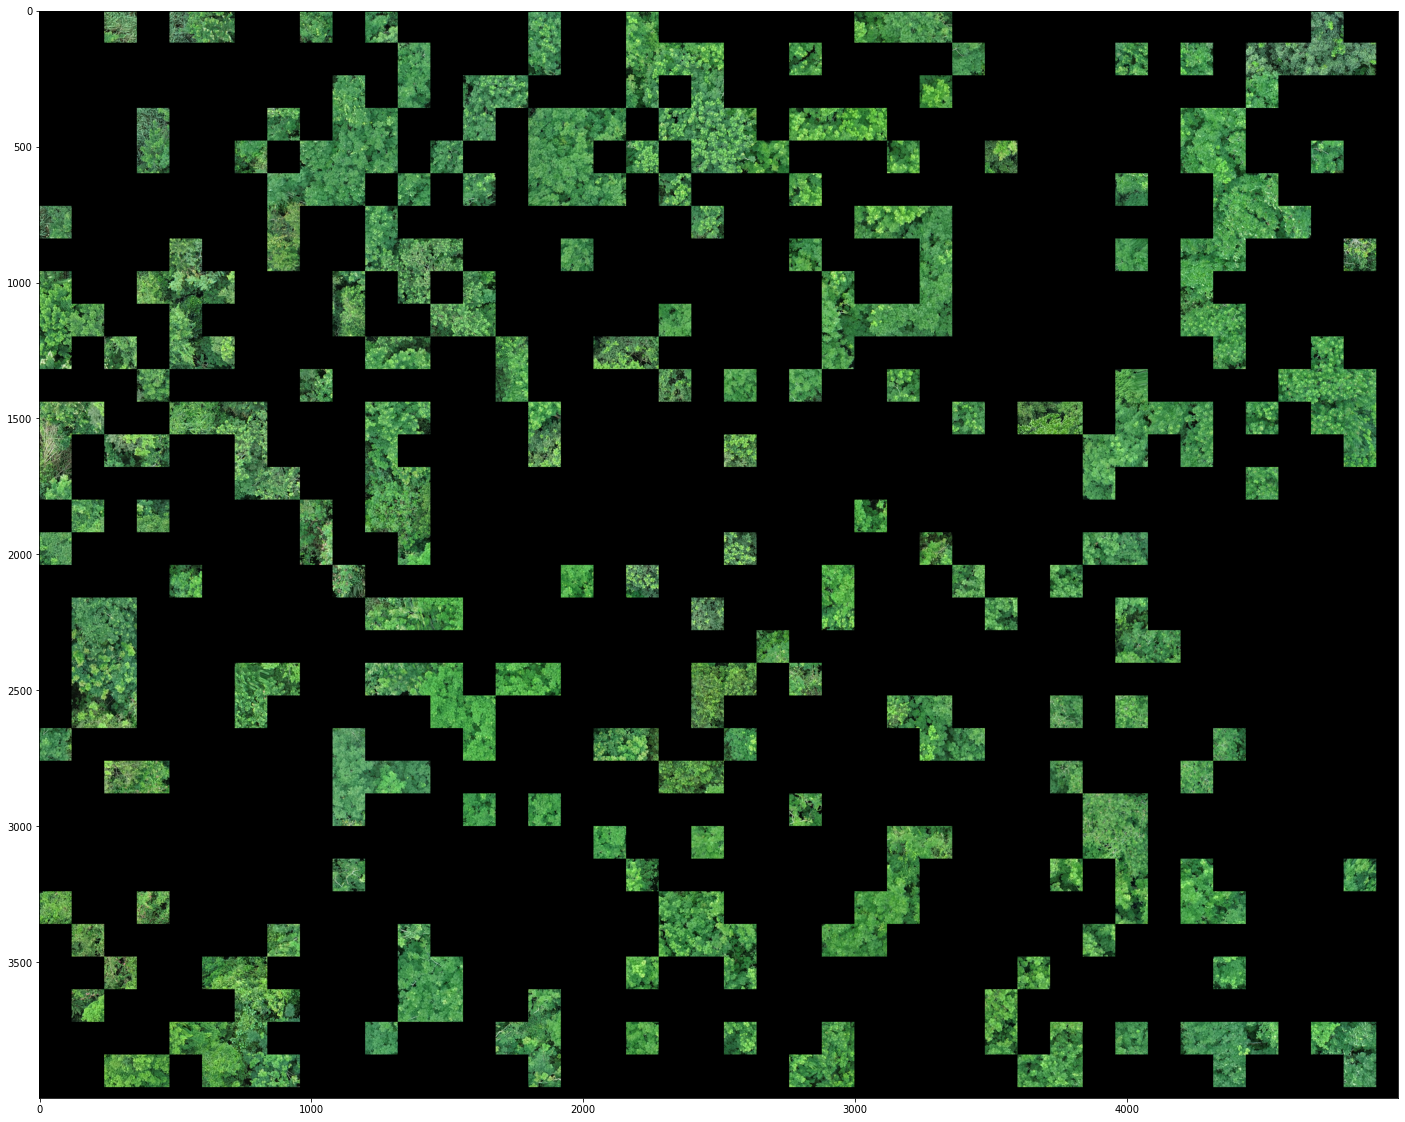

In [16]:
fig = plt.figure(figsize=(32, 20))
plt.imshow(masked[1])

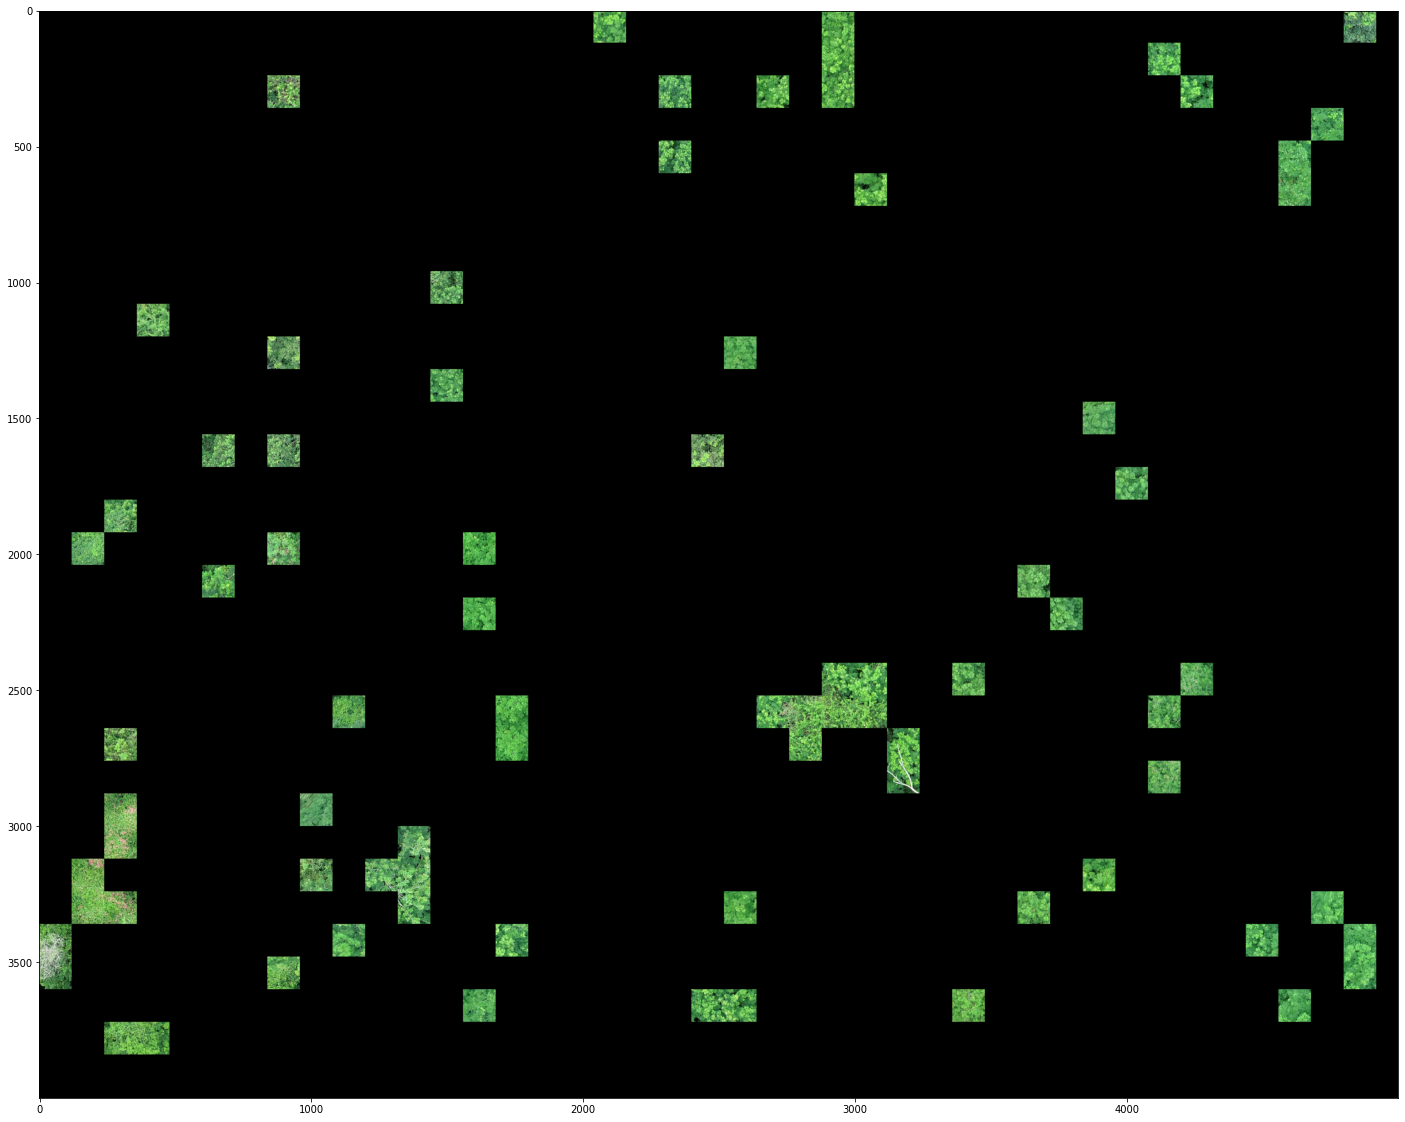

In [17]:
fig = plt.figure(figsize=(32, 20))
plt.imshow(masked[2])

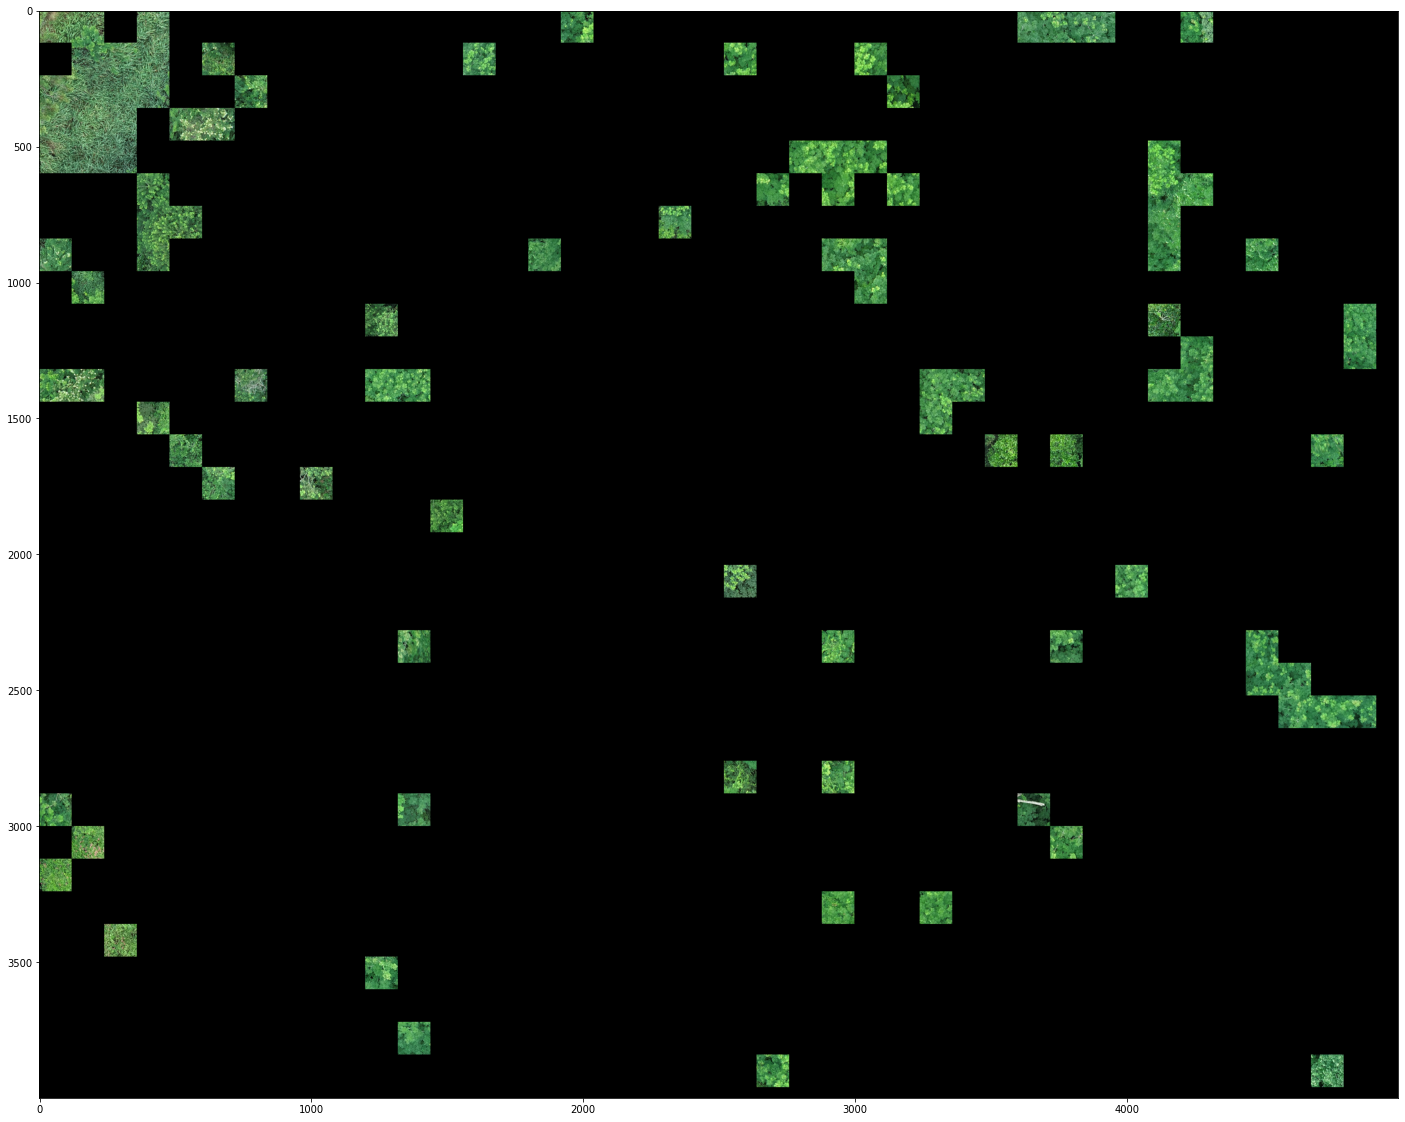

In [18]:
fig = plt.figure(figsize=(32, 20))
plt.imshow(masked[3])

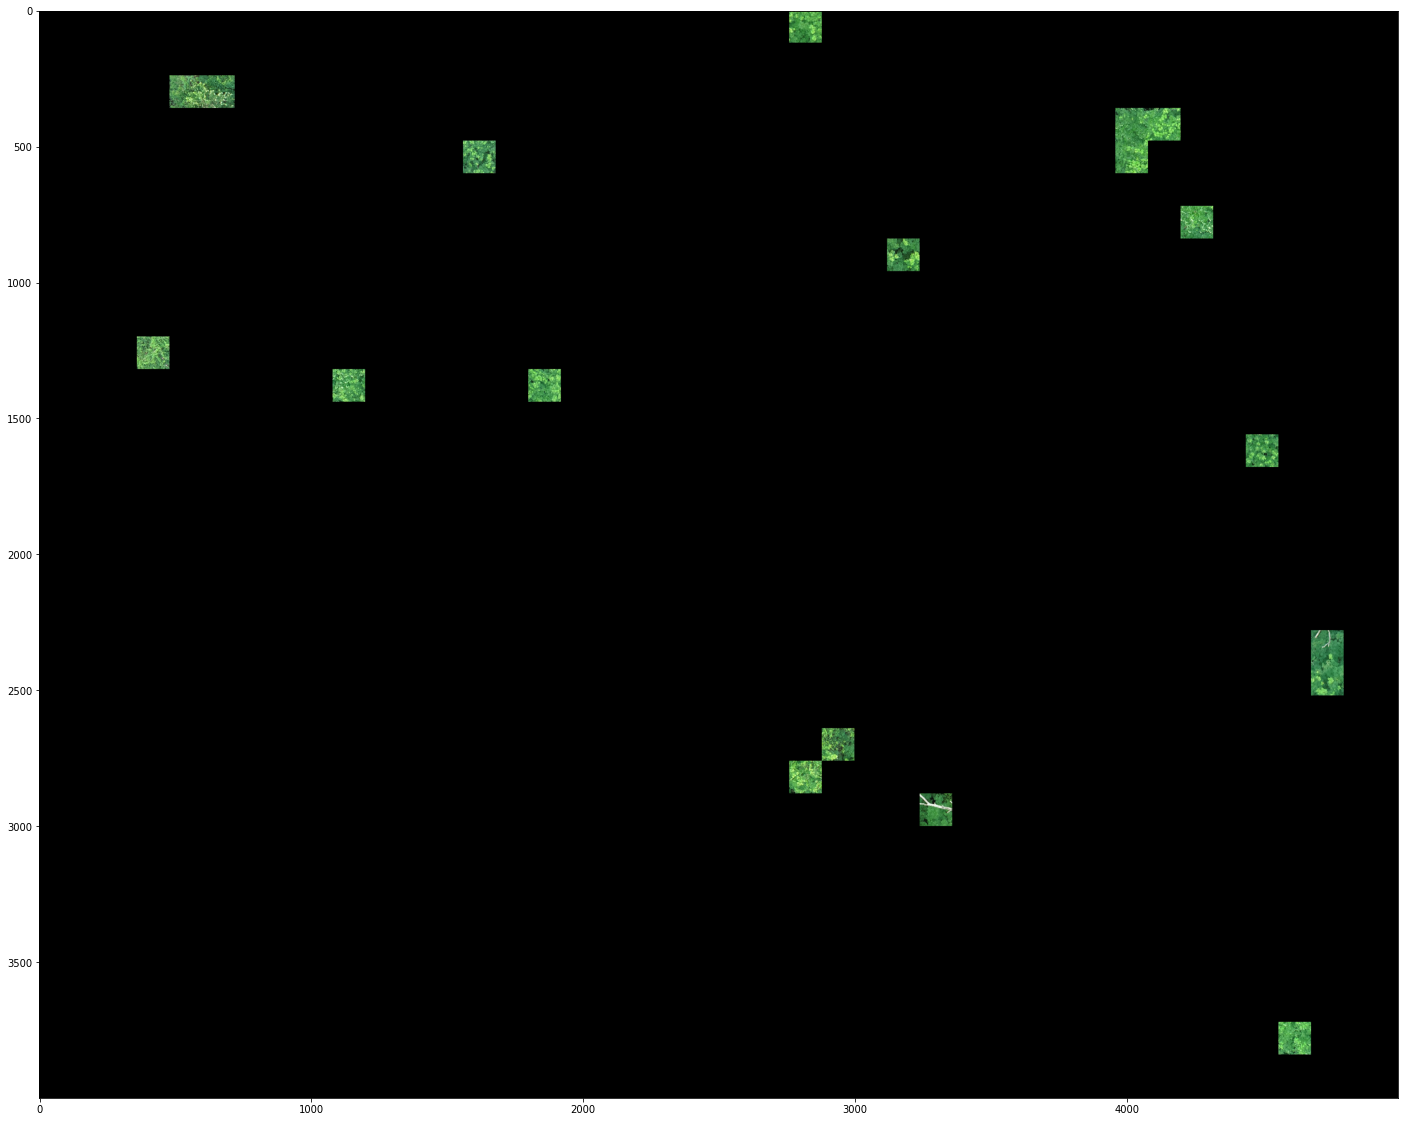

In [19]:
fig = plt.figure(figsize=(32, 20))
plt.imshow(masked[4])

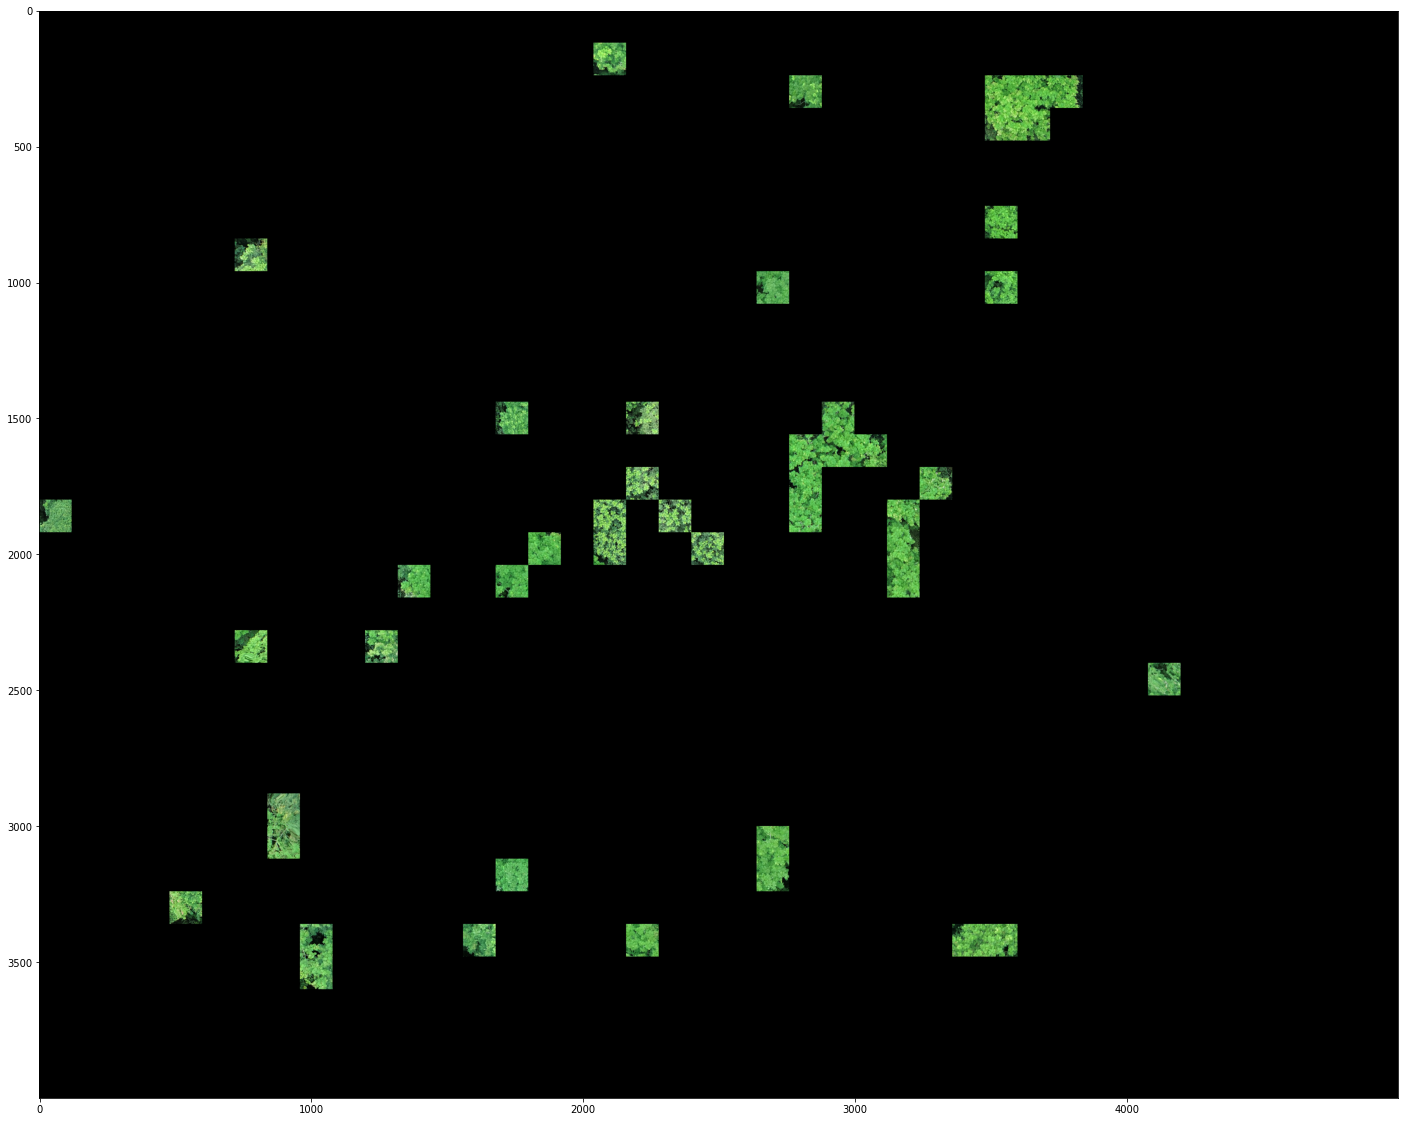

In [20]:
fig = plt.figure(figsize=(32, 20))
plt.imshow(masked[5])

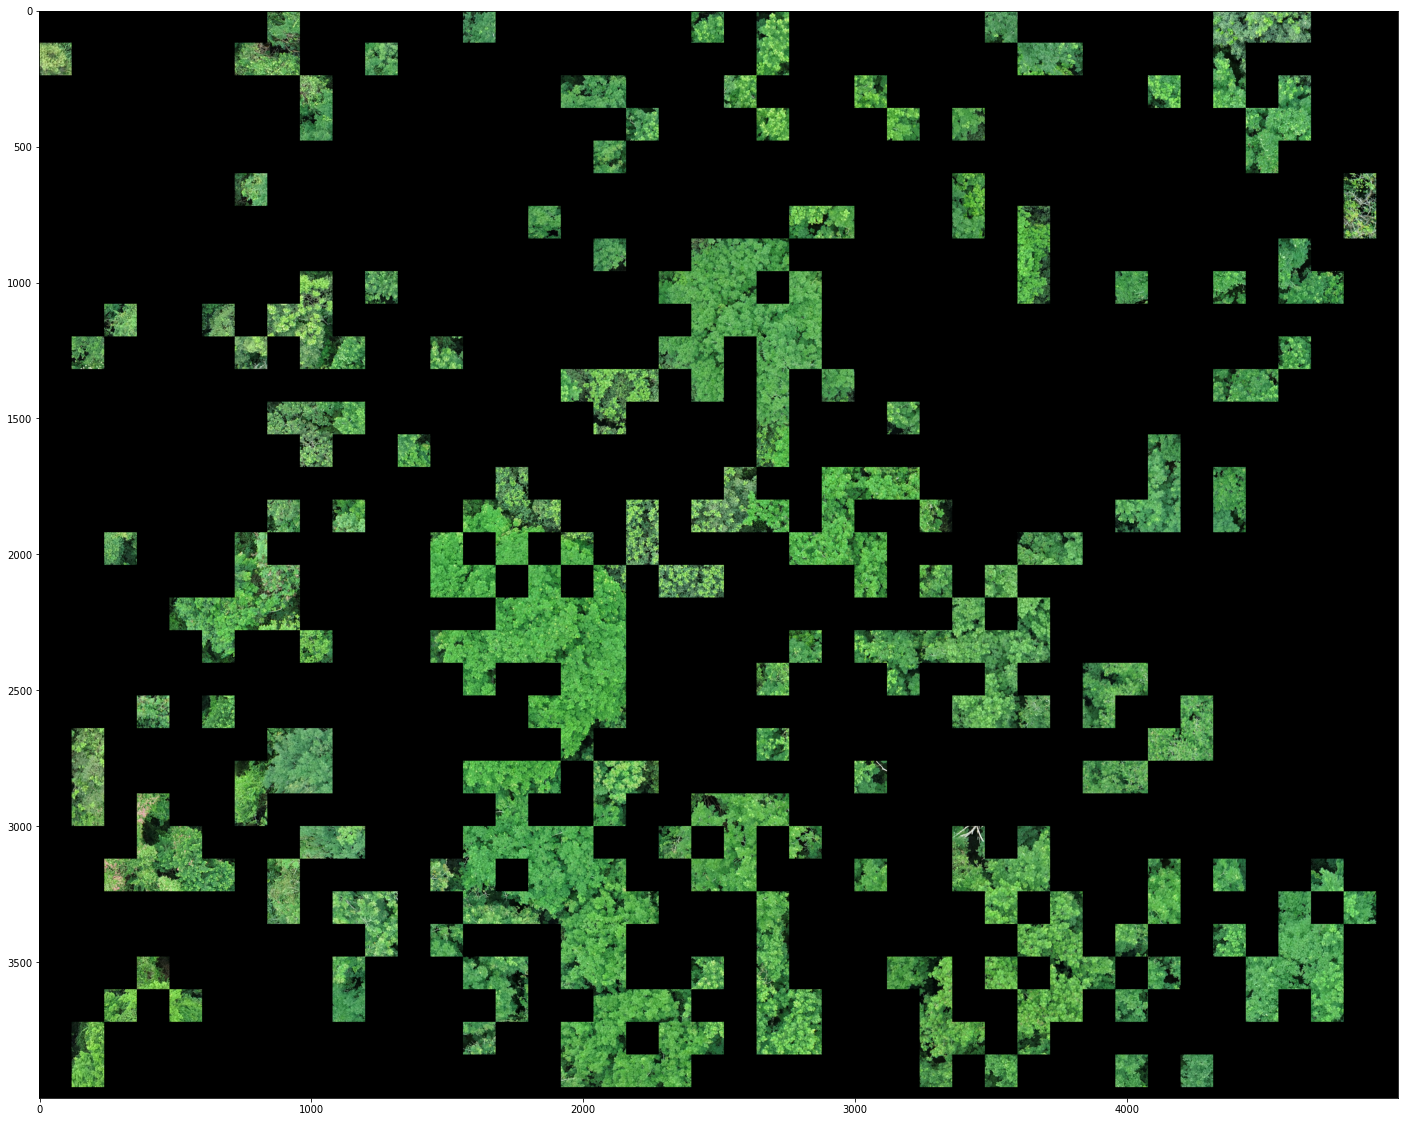

In [21]:
fig = plt.figure(figsize=(32, 20))
plt.imshow(masked[6])

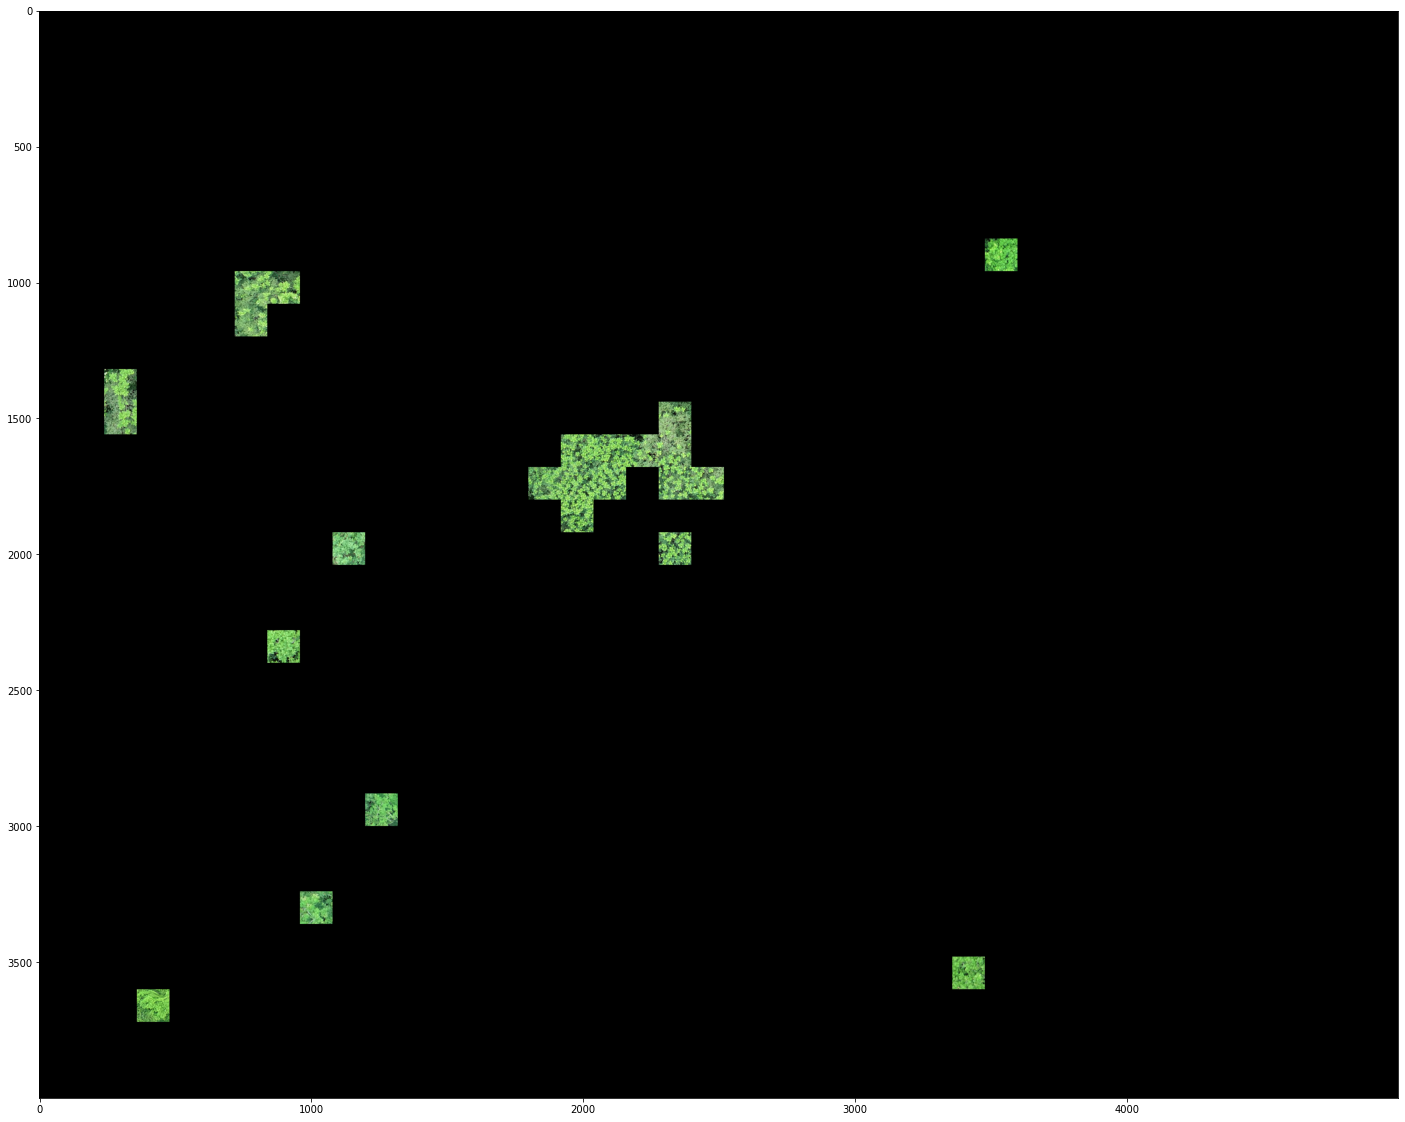

In [22]:
fig = plt.figure(figsize=(32, 20))
plt.imshow(masked[7])